In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, f1_score ,classification_report, mean_squared_error, recall_score, precision_score, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from xgboost import XGBClassifier, XGBRegressor

# Import scripts
from script_files.feature_engineering import *
from script_files.prepare_flight_data import *
from script_files.dummies import *
from script_files.predict import *

RSEED = 42

In [51]:
train_df = pd.read_csv('data/final_train.csv', index_col=[0])
train_df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,delayed,domestic,dep_hour,dep_weekday,duration_min,arr_hour,flight_month,flight_month_name,year,distance
0,train_id_15674,2016-01-01 00:00:00,TU 0564,NKC,TUN,2016-01-01 00:15:00,2016-01-01 04:30:00,ATA,TU 320IMV,0.0,...,0,0,0,Friday,255.0,4,1,January,2016,3298.067996
1,train_id_15676,2016-01-01 00:00:00,TU 0714,JED,TUN,2016-01-01 00:55:00,2016-01-01 05:30:00,ATA,TU 332IFM,195.0,...,1,0,0,Friday,275.0,5,1,January,2016,3256.052105
2,train_id_15675,2016-01-01 00:00:00,TU 0614,DKR,TUN,2016-01-01 01:20:00,2016-01-01 05:55:00,ATA,TU 320IMU,49.0,...,1,0,1,Friday,275.0,5,1,January,2016,3678.974557
3,train_id_30980,2016-01-01 00:00:00,UG 0002,TUN,DJE,2016-01-01 06:15:00,2016-01-01 07:15:00,SCH,UG AT7LBD,0.0,...,0,1,6,Friday,60.0,7,1,January,2016,333.916459
4,train_id_7179,2016-01-01 00:00:00,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09:20:00,ATA,TU 736IOP,36.0,...,1,0,6,Friday,170.0,9,1,January,2016,1770.371959


In [52]:
# List of dropping feature classification
drop_features_class = ['DATOP', 'ID','FLTID','STD', 'STA','target','icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR','arr_hour', 'flight_month_name','delay_or_onTime', 'delayed']

In [53]:
# List of dropping feature classification
drop_features_reg = ['DATOP', 'ID','FLTID','STD', 'STA','icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR','arr_hour', 'flight_month_name','delay_or_onTime', 'target']

In [54]:
# List of dropping feature classification
drop_features_reg_total = ['DATOP', 'ID','FLTID','STD', 'STA','icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR','arr_hour', 'flight_month_name','delay_or_onTime', 'target']

In [55]:
X_class = drop_column(train_df, drop_features_class)
y_class = train_df['delayed']

# For the regression 
X_reg = drop_column(train_df.query("delayed == 1"), drop_features_reg)
y_reg = train_df.query("delayed == 1")['target']

y_reg_total = train_df['target']
X_reg_total = drop_column(train_df, drop_features_reg_total)

In [56]:
# Train test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, stratify=y_class, random_state=RSEED)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RSEED)
X_train_reg_total, X_test_reg_total, y_train_reg_total, y_test_reg_total = train_test_split(X_reg_total, y_reg_total, test_size=0.2, random_state=RSEED)

In [57]:
# resetting indices
X_train_class.reset_index(drop=True, inplace=True)
X_test_class.reset_index(drop=True, inplace=True)
X_train_reg.reset_index(drop=True, inplace=True)
X_test_reg.reset_index(drop=True, inplace=True)
X_train_reg_total.reset_index(drop=True, inplace=True)
X_test_reg_total.reset_index(drop=True, inplace=True)

y_train_class.reset_index(drop=True, inplace=True)
y_test_class.reset_index(drop=True, inplace=True)
y_train_reg.reset_index(drop=True, inplace=True)
y_test_reg.reset_index(drop=True, inplace=True)
y_train_reg_total.reset_index(drop=True, inplace=True)
y_test_reg_total.reset_index(drop=True, inplace=True)

F1 macro avg. score: 0.615221666447493
              precision    recall  f1-score   support

           0       0.87      0.33      0.48     10002
           1       0.62      0.96      0.75     11565

    accuracy                           0.67     21567
   macro avg       0.75      0.64      0.62     21567
weighted avg       0.74      0.67      0.63     21567



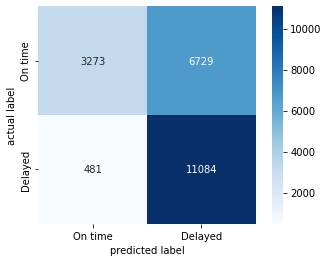

In [9]:
y_pred_dumm_class = dummie_class(X_test_class)
print('F1 macro avg. score:', f1_score(y_test_class, y_pred_dumm_class, average='macro'))
print(classification_report(y_test_class, y_pred_dumm_class))
plot_confusion_matrix(y_test_class, y_pred_dumm_class)

In [10]:
y_pred_dumm_reg = dummie_reg(X_test_reg)

In [11]:
print(mean_squared_error(y_test_reg, y_pred_dumm_reg))

21745.90446917423


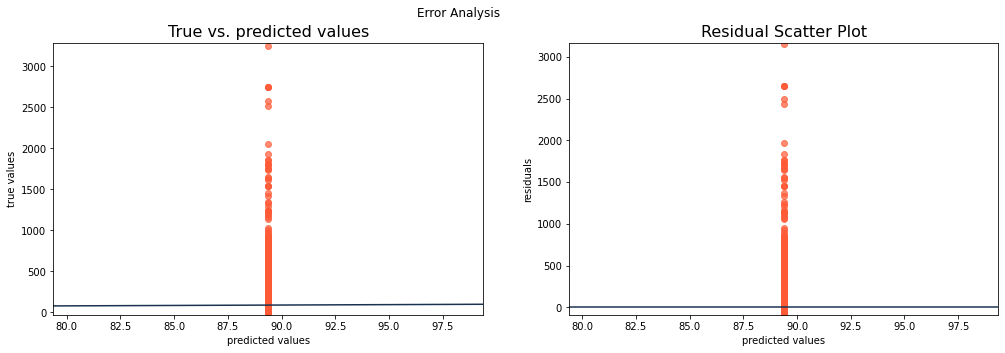

In [12]:
error_analysis(y_test_reg, y_pred_dumm_reg)

In [58]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = ['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'domestic', 'dep_hour', 'dep_weekday', 'flight_month', 'year']

num_features = ['duration_min', 'distance']

In [59]:
cat_features_reg_total = ['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'domestic', 'dep_hour', 'dep_weekday', 'flight_month', 'year']

num_features_reg_total = ['duration_min', 'distance']

In [60]:
one_hot_class = pd.get_dummies(X_train_class,columns=cat_features,drop_first=True)
dummie_column_labels_class = one_hot_class.columns

In [61]:
one_hot_reg = pd.get_dummies(X_train_reg,columns=cat_features,drop_first=True)
dummie_column_labels_reg = one_hot_reg.columns

In [62]:
one_hot_reg_total = pd.get_dummies(X_train_reg_total,columns=cat_features_reg_total,drop_first=True)
dummie_column_labels_reg_total = one_hot_reg_total.columns

In [63]:
scaler_class = StandardScaler()
scaler_class.fit(X_train_class[num_features])
X_train_class[num_features] = scaler_class.transform(X_train_class[num_features])
X_test_class[num_features] = scaler_class.transform(X_test_class[num_features])

encoder_class = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_class.fit(X_train_class[cat_features])

X_train_dummie_columns = pd.DataFrame(encoder_class.transform(X_train_class[cat_features]))
X_train_class = X_train_class.drop(cat_features, axis=1)
X_train_class = X_train_class.join(X_train_dummie_columns)
X_train_class.columns = dummie_column_labels_class

X_test_dummie_columns = pd.DataFrame(encoder_class.transform(X_test_class[cat_features]))
X_test_class = X_test_class.drop(cat_features, axis=1)
X_test_class = X_test_class.join(X_test_dummie_columns)
X_test_class.columns = dummie_column_labels_class


In [64]:
scaler_reg = StandardScaler()
scaler_reg.fit(X_train_reg[num_features])
X_train_reg[num_features] = scaler_reg.transform(X_train_reg[num_features])
X_test_reg[num_features] = scaler_reg.transform(X_test_reg[num_features])

encoder_reg = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_reg.fit(X_train_reg[cat_features])

X_train_dummie_columns = pd.DataFrame(encoder_reg.transform(X_train_reg[cat_features]))
X_train_reg = X_train_reg.drop(cat_features, axis=1)
X_train_reg = X_train_reg.join(X_train_dummie_columns)
X_train_reg.columns = dummie_column_labels_reg

X_test_dummie_columns = pd.DataFrame(encoder_reg.transform(X_test_reg[cat_features]))
X_test_reg = X_test_reg.drop(cat_features, axis=1)
X_test_reg = X_test_reg.join(X_test_dummie_columns)
X_test_reg.columns = dummie_column_labels_reg

In [65]:
scaler_reg_total = StandardScaler()
scaler_reg_total.fit(X_train_reg_total[num_features_reg_total])
X_train_reg_total[num_features_reg_total] = scaler_reg_total.transform(X_train_reg_total[num_features_reg_total])
X_test_reg_total[num_features_reg_total] = scaler_reg_total.transform(X_test_reg_total[num_features_reg_total])

encoder_reg_total = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_reg_total.fit(X_train_reg_total[cat_features_reg_total])

X_train_dummie_columns = pd.DataFrame(encoder_reg_total.transform(X_train_reg_total[cat_features_reg_total]))
X_train_reg_total = X_train_reg_total.drop(cat_features_reg_total, axis=1)
X_train_reg_total = X_train_reg_total.join(X_train_dummie_columns)
X_train_reg_total.columns = dummie_column_labels_reg_total

X_test_dummie_columns = pd.DataFrame(encoder_reg_total.transform(X_test_reg_total[cat_features_reg_total]))
X_test_reg_total = X_test_reg_total.drop(cat_features_reg_total, axis=1)
X_test_reg_total = X_test_reg_total.join(X_test_dummie_columns)
X_test_reg_total.columns = dummie_column_labels_reg_total

In [18]:
models_class = []

models_class.append(('KNN', KNeighborsClassifier()))
models_class.append(('SVC', SVC()))
models_class.append(('LR', LogisticRegression()))
models_class.append(('DT', DecisionTreeClassifier()))
models_class.append(('RF', RandomForestClassifier()))
models_class.append(('GNB', GaussianNB()))
models_class.append(('XGB', XGBClassifier()))
models_class.append(("ADA", AdaBoostClassifier()))
models_class.append(("SGD", SGDClassifier()))

In [19]:
# Test different types of models
names = []
f1_scores = []
y_pred_class = []
i = 0

for name, model in models_class:
    model.fit(X_train_class, y_train_class)
    y_pred_class.append(model.predict(X_test_class))
    f1_scores.append(f1_score(y_test_class, y_pred_class[i], average='macro'))
    names.append(name)
    print(names[i])
    i += 1
    
tr_split = pd.DataFrame({'Name': names,"F1":f1_scores})
print(tr_split)

KNN
SVC
LR
DT
RF
GNB
XGB
ADA
SGD
  Name        F1
0  KNN  0.718998
1  SVC  0.752419
2   LR  0.729326
3   DT  0.694993
4   RF  0.730706
5  GNB  0.618880
6  XGB  0.747895
7  ADA  0.712340
8  SGD  0.714985


KNN
              precision    recall  f1-score   support

           0       0.72      0.67      0.69     10002
           1       0.73      0.77      0.75     11565

    accuracy                           0.72     21567
   macro avg       0.72      0.72      0.72     21567
weighted avg       0.72      0.72      0.72     21567



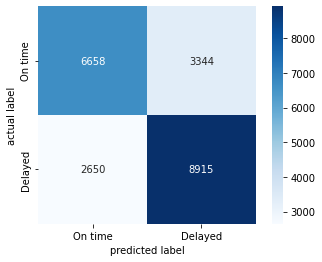

SVC
              precision    recall  f1-score   support

           0       0.78      0.66      0.72     10002
           1       0.74      0.84      0.79     11565

    accuracy                           0.76     21567
   macro avg       0.76      0.75      0.75     21567
weighted avg       0.76      0.76      0.76     21567



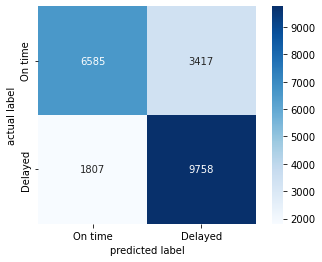

LR
              precision    recall  f1-score   support

           0       0.76      0.62      0.69     10002
           1       0.72      0.83      0.77     11565

    accuracy                           0.74     21567
   macro avg       0.74      0.73      0.73     21567
weighted avg       0.74      0.74      0.73     21567



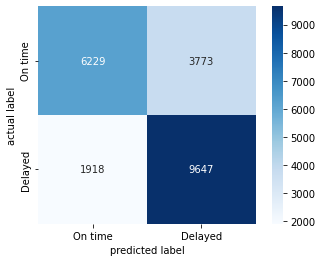

DT
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     10002
           1       0.72      0.71      0.71     11565

    accuracy                           0.70     21567
   macro avg       0.69      0.70      0.69     21567
weighted avg       0.70      0.70      0.70     21567



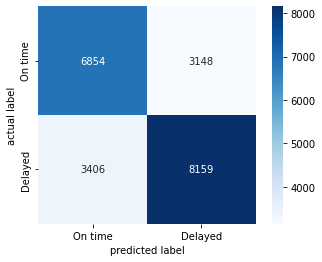

RF
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     10002
           1       0.73      0.79      0.76     11565

    accuracy                           0.73     21567
   macro avg       0.73      0.73      0.73     21567
weighted avg       0.73      0.73      0.73     21567



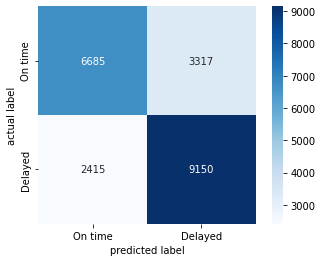

GNB
              precision    recall  f1-score   support

           0       0.91      0.32      0.48     10002
           1       0.62      0.97      0.76     11565

    accuracy                           0.67     21567
   macro avg       0.77      0.65      0.62     21567
weighted avg       0.76      0.67      0.63     21567



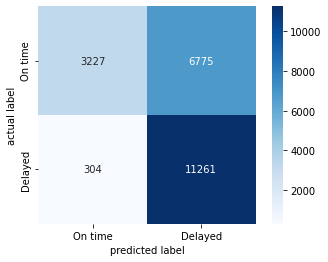

XGB
              precision    recall  f1-score   support

           0       0.78      0.65      0.71     10002
           1       0.74      0.84      0.79     11565

    accuracy                           0.75     21567
   macro avg       0.76      0.75      0.75     21567
weighted avg       0.76      0.75      0.75     21567



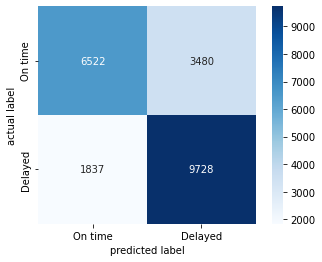

ADA
              precision    recall  f1-score   support

           0       0.78      0.57      0.66     10002
           1       0.70      0.86      0.77     11565

    accuracy                           0.72     21567
   macro avg       0.74      0.71      0.71     21567
weighted avg       0.73      0.72      0.72     21567



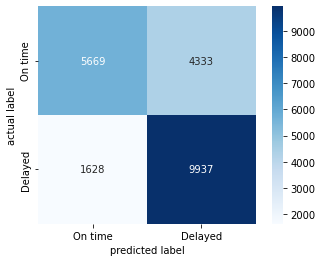

SGD
              precision    recall  f1-score   support

           0       0.80      0.55      0.65     10002
           1       0.69      0.88      0.78     11565

    accuracy                           0.73     21567
   macro avg       0.75      0.72      0.71     21567
weighted avg       0.74      0.73      0.72     21567



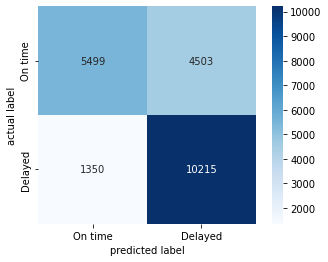

In [22]:
for i in range(len(models_class)):
    print(names[i])
    print(classification_report(y_test_class, y_pred_class[i]))
    plot_confusion_matrix(y_test_class, y_pred_class[i])

SVC and XGB with gbtree are the best models in average F1 score. A gridsearch will be performed on them.

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 9585
max_resources_: 86266
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 9585
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END C=0.01, gamma=0.01;, score=(train=0.350, test=0.346) total time=  13.4s
[CV 2/3] END C=0.01, gamma=0.01;, score=(train=0.351, test=0.354) total time=  12.6s
[CV 3/3] END C=0.01, gamma=0.01;, score=(train=0.348, test=0.350) total time=  12.9s
[CV 1/3] END C=0.01, gamma=0.06;, score=(train=0.627, test=0.636) total time=  12.6s
[CV 2/3] END C=0.01, gamma=0.06;, score=(train=0.634, test=0.636) total time=  12.6s
[CV 3/3] END C=0.01, gamma=0.06;, score=(train=0.635, test=0.636) total time=  12.5s
[CV 1/3] END C=0.01, gamma=0.1;, score=(train=0.627, test=0.635) total time=  12.7s
[CV 2/3] END C=0.01, gamma=0.1;, score=(train=0.634, test=0.636) total time=  12.6s
[CV 3/3] END C=0.01, gamma=0.1;, score=(train=0.634, test=

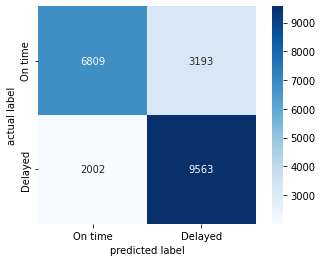

In [22]:
# Initialize the SVC classifier
SVC_clf = SVC(kernel='rbf',cache_size=1000) 

# Create the parameters list 
parameters = {'C':[0.01, 0.1, 1, 10],                 
              'gamma':[0.01, 0.06, 0.1, 0.6]                          
             } 

# making a macro average f1 scorer
scorer = make_scorer(f1_score,average='macro') 


# Perform grid search on the classifier using macro average f1 score as the scoring method
SVC_gridsearch = HalvingGridSearchCV(SVC_clf, parameters, scoring=scorer, cv=3, verbose=4)

# Fit the grid search object to the training data and find the optimal parameters
SVC_gridsearch.fit(X_train_class, y_train_class)

# get the best clf
best_SVC_clf = SVC_gridsearch.best_estimator_

# Make predictions using the optimized model
SVC_best_predictions = best_SVC_clf.predict(X_test_class)

# print the classification report and the confusion matrix of the best model
print(classification_report(y_test_class, SVC_best_predictions))
plot_confusion_matrix(y_test_class, SVC_best_predictions)

In [23]:
print(best_SVC_clf.get_params)

<bound method BaseEstimator.get_params of SVC(C=10, cache_size=1000, gamma=0.06)>


In [28]:
print('Optimal SVC F1 macro average:', f1_score(y_test_class, SVC_best_predictions, average='macro'))

Optimal SVC F1 macro average: 0.7551298727103789


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 37
max_resources_: 81848
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2916
n_resources: 37
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[CV 1/5] END alpha=0, eta=0.1, gamma=0, lambda=0, max_depth=3, min_child_weight=1, subsample=0.5;, score=(train=0.854, test=0.417) total time=   0.4s
[CV 2/5] END alpha=0, eta=0.1, gamma=0, lambda=0, max_depth=3, min_child_weight=1, subsample=0.5;, score=(train=0.861, test=0.708) total time=   0.1s
[CV 3/5] END alpha=0, eta=0.1, gamma=0, lambda=0, max_depth=3, min_child_weight=1, subsample=0.5;, score=(train=0.875, test=0.125) total time=   0.1s
[CV 4/5] END alpha=0, eta=0.1, gamma=0, lambda=0, max_depth=3, min_child_weight=1, subsample=0.5;, score=(train=0.813, test=0.533) total time=   0.1s
[CV 5/5] END alpha=0, eta=0.1, gamma=0, lambda=0, max_depth=3, min_child_weight=1, subsample=0.5;, score=(train=0.862, test=0.222) to

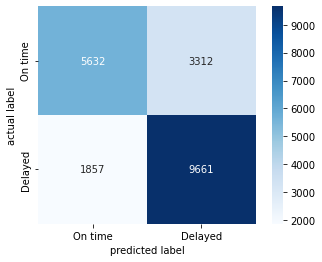

In [66]:
# Initialize the XGB classifier
XGB_clf = XGBClassifier() 

# Create the parameters list 
parameters_XGB = {'eta':[0.1,0.3,0.7],                 
                'gamma':[0, 0.1, 1],
                'max_depth':[3,6,9,12],  
                'min_child_weight':[1,5,10],
                'subsample':[0.5, 0.8, 1],  
                'lambda':[0,0.5,1],
                'alpha':[0,0.5,1]              
             } 

# making a macro average f1 scorer
scorer = make_scorer(f1_score,average='macro') 

# Perform grid search on the classifier using macro average f1 score as the scoring method
XGB_gridsearch = HalvingGridSearchCV(XGB_clf, parameters_XGB, scoring=scorer, cv=5, verbose=4)

# Fit the grid search object to the training data and find the optimal parameters
XGB_gridsearch.fit(X_train_class, y_train_class)

# get the best clf
best_XGB_clf = XGB_gridsearch.best_estimator_

# Make predictions using the optimized model
XGB_best_predictions = best_XGB_clf.predict(X_test_class)

# print the classification report and the confusion matrix of the best model
print('XGBC f1 macro average:', f1_score(y_test_class, XGB_best_predictions, average='macro'))
print('best params:',best_XGB_clf.get_params)
print(classification_report(y_test_class, XGB_best_predictions))
plot_confusion_matrix(y_test_class, XGB_best_predictions)

best params: <bound method XGBModel.get_params of XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=0,
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)>
XGBC f1 macro average: 0.7371964430515948
              precision    recall  f1-score   support

           0       0.75      0.63      0.69      8944
           1       0.74      0.84      0.79     11518

    accuracy                           0.75     20462
   macro avg      

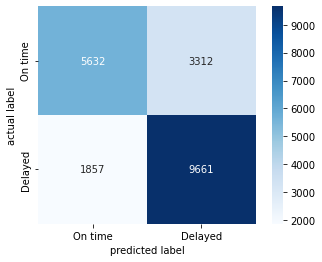

In [67]:
print('best params:',best_XGB_clf.get_params)
print('XGBC f1 macro average:', f1_score(y_test_class, XGB_best_predictions, average='macro'))
print(classification_report(y_test_class, XGB_best_predictions))
plot_confusion_matrix(y_test_class, XGB_best_predictions)